In [1]:
import pandas as pd
import numpy as np
import math
from datetime import date
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.interpolate import CubicSpline
from scipy.misc import derivative
import matplotlib.pyplot as plt

# Stock Prices on 27/10

In [2]:
S0_700  = 292.800
S0_0005 = 57.268
S0_941  = 62.850

# Risk Free Rate

In [3]:
#we assume risk-free rate and continuous dividend yield to be constant for simplicity
rf= 0.044667

# Estimating the dividend yield through Put Call Parity

In [4]:
Put_0005 = pd.read_csv("0005_Put.csv", index_col = 0, header = 0)
Call_0005 = pd.read_csv("0005_Call.csv", index_col=0, header = 0)
Put_0005.index = pd.to_datetime(Put_0005.index, format = "%d/%m/%Y")
Call_0005.index = pd.to_datetime(Call_0005.index, format = "%d/%m/%Y")

Put_941 = pd.read_csv("941_Put.csv", index_col = 0, header = 0)
Call_941 = pd.read_csv("941_Call.csv", index_col = 0, header = 0)
Put_941.index = pd.to_datetime(Put_941.index, format = "%d/%m/%Y")
Call_941.index = pd.to_datetime(Call_941.index, format = "%d/%m/%Y")



Put_700 = pd.read_csv("700_Put.csv", index_col = 0, header = 0)
Call_700 = pd.read_csv("700_Call.csv", index_col = 0, header = 0)
Put_700.index = pd.to_datetime(Put_700.index, format = "%d/%m/%Y")
Call_700.index = pd.to_datetime(Call_700.index, format = "%d/%m/%Y")



In [5]:
#maturity we used for options
Call_700.index.unique()

DatetimeIndex(['2023-10-30', '2023-11-29', '2023-12-28', '2024-01-30',
               '2024-03-27', '2024-06-27', '2024-09-27'],
              dtype='datetime64[ns]', name='Expiry Date', freq=None)

In [6]:
def dividend_estimation(S0, rf, Call_Price, Put_Price):
    dividend_list = []
    for dates in Put_Price.index.unique():
        #we only use ATM that strike to estimate the dividend yield 
        #since it has the most liquidity and gives more accurate results
        Call_price = list(map(lambda x,y: (x+y)/2,Call_Price.loc[Call_Price.index == dates, "Bid"].tolist(),Call_Price.loc[Call_Price.index == dates , "Ask"].tolist()))
        Put_price  = list(map(lambda x,y: (x+y)/2,Put_Price.loc[Put_Price.index == dates , "Bid"].tolist(),Put_Price.loc[Put_Price.index == dates , "Ask"].tolist()))
        C_min_P = map(lambda x,y: x-y, Call_price, Put_price)
        strike = Put_Price.loc[Put_Price.index == dates, "Strike"].tolist()
        strike = [K*np.exp(-rf*(3+ ((dates.year-2023)*12+dates.month-10)*21)/252) for K in strike]
        dividends = map(lambda x,y: np.log((x+y)/S0)*(-1/((2+((dates.year-2023)*12+dates.month-10)*21)/252)),C_min_P, strike)
        dividends = map(lambda x: np.maximum(0,x), list(dividends))
        dividends = np.mean(list(dividends))
        dividend_list.append(dividends)
    return np.mean(dividend_list)


In [7]:
q_0005 = dividend_estimation(S0_0005, rf, Call_0005, Put_0005)
q_700 = dividend_estimation(S0_700, rf, Call_700, Put_700)
q_941 = dividend_estimation(S0_941, rf, Call_941, Put_941)

In [8]:
q_0005, q_700, q_941

(0.04381506377660647, 0.029034348980198004, 0.0945491089515288)

# Get Implied Volatility at specific points

In [9]:
#idea: for each maturity, fit the implied volatility given in the notes,
#then, when we input a specific K and T, run cublic splines on that K across different maturities

In [10]:
#function stated in the notes
def implied_var_curve(delta, gamma, kappa, atm_vol, x):
    #change to log moneyness
    #put in the np.max to avoid negative variance during the optimization process
    return  atm_vol**2+delta*(math.tanh(kappa*x)/kappa)+(gamma/2)*(math.tanh(kappa*x)/kappa)**2

#function to find implied vol
def European_option_pricer(S,K,r,q,T,sig,isCall = True):
    d1 = (np.log(S/K)+(r-q+(sig**2)/2)*T)/(sig*(T**0.5))
    d2 = d1 - sig*(T**0.5)
    
    if isCall:
        return S*math.exp(-q*T)*norm.cdf(d1)-K*math.exp(-r*T)*norm.cdf(d2)
    else:
        return K*math.exp(-r*T)*norm.cdf(-d2)-S*math.exp(-q*T)*norm.cdf(-d1)

def implied_vol_bisection(V,S,K,r,q,T,option_pricer = European_option_pricer,isCall = True, tol = 0.00001):
    #V is the option price, either call or put price
    
    def f(sig): #function of sigma that returns the option price
        return option_pricer(S,K,r,q,T,sig,isCall)
    
    sig1 = 0.001 #Left sigma
    if f(sig1) >V:
         return ("Impossible to reach this option price solely changing the volatility")
    sig2 = 100 #right sigma
    while not(f(sig1)<V and f(sig2)>V):
        sig2+=0.2 #incrementing the bound until the true option price is within the sigma range
    sig_mean = (sig1+sig2)/2 #mid point
    
    while abs(f(sig_mean) - V) > tol: #iterating until the absolute difference is less than the tolerance level
        if f(sig_mean)-V>0: #it means it the sigma is on the RHS of the true sigma (since it's an increasing function)
            sig2 = sig_mean
            sig_mean = (sig1+sig2)/2 
        else:
            sig1 = sig_mean
            sig_mean = (sig1+sig2)/2
    return sig_mean

In [11]:
#function to find out the ATM vol
#we use the average of the closest strike price implied vol between Put and Call
#we take the closest strike and use the average of call and put implied vol
def atm_vol_cal(S0, Put_df, Call_df,T, r,q):
    closest_strike = min(Put_df.Strike.unique(), key=lambda x: abs(S0 - x))
    Call_implied_vol = implied_vol_bisection((Call_df.loc[Call_df["Strike"]==closest_strike, "Bid"].squeeze()+
                                              Call_df.loc[Call_df["Strike"]==closest_strike, "Ask"].squeeze())/2, S0, closest_strike, r, q, T, isCall=True)
    Put_implied_vol = implied_vol_bisection((Put_df.loc[Put_df["Strike"]==closest_strike, "Bid"].squeeze()+
                                            Put_df.loc[Put_df["Strike"]==closest_strike, "Ask"].squeeze())/2, S0, closest_strike, r, q, T, isCall=False)
    return np.mean([Call_implied_vol,Put_implied_vol])

In [12]:
### get iv for all strikes
def return_iv_df(S0, Put_df, Call_df,T,r,q,atm_vol):  
    otm_put_strikes = [float(K) for K in Put_df['Strike'] if K <= S0]
    otm_call_strikes = [float(K) for K in Call_df['Strike'] if K > S0]
    all_strike_levels = otm_put_strikes + otm_call_strikes
    closest_strike = min(Put_df.Strike.unique(), key=lambda x: abs(S0 - x))
    iv = pd.DataFrame(index = [T], columns = all_strike_levels)
    for j in range(len(iv.columns)):
        K = float(iv.columns[j])
        if K == closest_strike:
            iv.iloc[0,j] = atm_vol
        elif K<closest_strike:
            V = (Put_df.loc[Put_df["Strike"]==K, "Bid"].squeeze() +Put_df.loc[Put_df["Strike"]==K, "Ask"].squeeze())/2
            isCall = False
            iv.iloc[0,j] = implied_vol_bisection(V,S0,K,r,q,T,isCall=isCall)
        elif K > closest_strike:
            V = (Call_df.loc[Call_df["Strike"] == K, "Bid"].squeeze()+Call_df.loc[Call_df["Strike"] == K, "Ask"].squeeze())/2
            isCall = True
            iv.iloc[0,j] = implied_vol_bisection(V,S0,K,r,q,T,isCall=isCall)

    return iv


# Convert Implied vol to Local vol

In [13]:
#Convert option prices to local vol using dupire formula
def dupire(S,K,r,q,T,sig,isCall = True):
    dt = 1/252
    dC_dT = (European_option_pricer(S,K,r,q,T+dt,sig,isCall) - European_option_pricer(S,K,r,q,T,sig,isCall))/dt
    
    dk = 0.05
    d2C_dK2 = (European_option_pricer(S,K+dk,r,q,T,sig,isCall)
               -2*European_option_pricer(S,K,r,q,T,sig,isCall)
               +European_option_pricer(S,K-dk,r,q,T,sig,isCall))/(dk**2)
    return np.sqrt(dC_dT/(0.5*K**2*d2C_dK2))

#return a dataframe containing local vol at specific points and time using Dupire's formula
def return_lcv_df(iv,S0,r,q):
    lcv = pd.DataFrame(index = iv.index, columns = iv.columns)

    for i in range(len(iv)):
        T = float(iv.index[i])
        for j in range(len(iv.columns)):
            K = float(iv.columns[j])
            isCall = False if K < S0 else True
            sig = iv.iloc[i,j]
            lcv.iloc[i,j] = dupire(S0,K,r,q,T,sig,isCall)
    return lcv

#Vol curve model
def implied_var_curve(x, atm_vol, skew, convex, wings):
        return atm_vol**2 + skew*(np.tanh(wings*x)/wings) + convex/2*(np.tanh(wings*x)/wings)**2

#Fit the paramater of the vol curve model    
def fit_param(vol_df,S0,atm_vol):
    x = np.log(pd.to_numeric(vol_df.columns.to_list())/S0)
    y = [vol**2 for vol in vol_df.iloc[0].to_list()]

    def obj(x, y, skew, convex, wings):
        return np.sum((y - implied_var_curve(x, atm_vol, skew, convex, wings))**2)

    res = minimize(lambda coeffs: obj(x,y,*coeffs), x0=(-1,1,3), method='SLSQP')
    #res = minimize(lambda coeffs: obj(x,y,*coeffs), x0=(-1,1,3), method='COBYLA')
    return res.x

#Fit the paramater of the vol curve model across different maturity
def fit_param_across_dates(S0, Put_df, Call_df, r, q):
    param = pd.DataFrame(index = Put_df.index.unique()[1:], columns = ['skew', 'convex', 'wings'])
    atm_vols_df = pd.DataFrame(index = Put_df.index.unique()[1:], columns = ['atm_vol'])
    for i in range(len(param.index)):
        date = param.index[i]
        T = (2+ ((date.year-2023)*12+date.month-10)*21)/252
        sub_put_df = Put_df[(Put_df.index == date) ]
        sub_call_df = Call_df[(Call_df.index == date)]
        atm_vol = atm_vol_cal(S0, sub_put_df, sub_call_df, T, r, q)
        iv = return_iv_df(S0, sub_put_df, sub_call_df, T, r, q, atm_vol)
        lcv = return_lcv_df(iv,S0,r,q)
        param.iloc[i] = fit_param(lcv,S0,atm_vol)
        atm_vols_df.iloc[i] = atm_vol
    return param, atm_vols_df



In [14]:
fitted_param_0005, atm_vols_0005 = fit_param_across_dates(S0_0005, Put_0005, Call_0005, rf,q_0005)
fitted_param_700, atm_vols_700 = fit_param_across_dates(S0_700, Put_700, Call_700, rf,q_700)
fitted_param_941, atm_vols_941 = fit_param_across_dates(S0_941, Put_941, Call_941, rf,q_941)

In [15]:
fitted_param_0005, fitted_param_700, fitted_param_941
#atm_vols is the atm_vol across different maturities, fitted_param is the param for the curve at different maturity, maturities is in terms of years

(                 skew    convex     wings
 Expiry Date                              
 2023-11-29  -0.181517  3.413066  0.819795
 2023-12-28  -0.143298   2.02804  1.590123
 2024-01-30  -0.108187  1.817484  2.868821
 2024-03-27  -0.120957  0.477115  0.044155
 2024-06-27  -0.133142  0.633507  3.181114
 2024-09-27  -0.101119  0.508155  3.222389,
                  skew    convex     wings
 Expiry Date                              
 2023-11-29  -0.019711  3.224492  2.645875
 2023-12-28   -0.01061  1.933852  2.860166
 2024-01-30   0.011098  1.150055  3.043473
 2024-03-27   0.043466  0.950282  3.095694
 2024-06-27    0.04976  0.527904  3.156023
 2024-09-27   0.084996 -0.022134   3.27603,
                  skew    convex     wings
 Expiry Date                              
 2023-11-29  -0.033354  3.544059  0.000349
 2023-12-28  -0.038087  1.367212  0.027137
 2024-01-30    -0.0272  1.353513  2.999898
 2024-03-27  -0.014969   0.77924  3.170473
 2024-06-27  -0.007262   0.22202  3.322741
 2024-09-

In [16]:
atm_vols_0005, atm_vols_700, atm_vols_941
#atm_vols is the atm_vol across different maturities, fitted_param is the param for the curve at different maturity, maturities is in terms of years

(              atm_vol
 Expiry Date          
 2023-11-29   0.273414
 2023-12-28   0.245922
 2024-01-30   0.238401
 2024-03-27   0.261362
 2024-06-27   0.240229
 2024-09-27   0.233443,
               atm_vol
 Expiry Date          
 2023-11-29   0.308002
 2023-12-28   0.301503
 2024-01-30   0.304507
 2024-03-27   0.305103
 2024-06-27   0.306642
 2024-09-27   0.310638,
               atm_vol
 Expiry Date          
 2023-11-29   0.188511
 2023-12-28   0.186397
 2024-01-30   0.187698
 2024-03-27   0.187532
 2024-06-27   0.199867
 2024-09-27   0.204552)

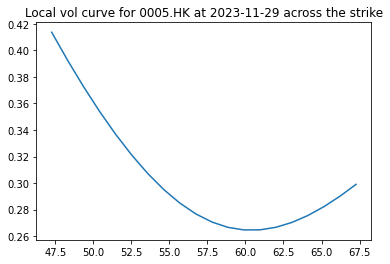

In [17]:
def plot_local_vol_curve(S0, fitted_param, atm_vols_df, date):
    date = pd.to_datetime(date)
    atm_vol = float(atm_vols_df.loc[date])
    skew, convex, wings = fitted_param.loc[date]
    x = np.linspace(S0-10,S0+10,20)
    y = np.sqrt(implied_var_curve(np.log(x/S0),atm_vol,skew,convex,wings))
    plt.plot(x,y)
    plt.title(f"Local vol curve for 0005.HK at {str(date)[:10]} across the strike")

#Local vol curve for 0005.HK at 2023-11-29 across the strike
plot_local_vol_curve(S0_0005, fitted_param_0005, atm_vols_0005, '2023-11-29')

# Local vol surface

In [18]:
#Return local vol given any time and strike
def local_vol(t,K,S0,fitted_param,atm_vols_df): 
    dates = [(2+ ((date.year-2023)*12+date.month-10)*21)/252 for date in pd.to_datetime(fitted_param.index.to_list())]
    vols = []
    for i in range(len(fitted_param)):
        atmvol = float(atm_vols_df.iloc[i])
        skew, convex, wings = fitted_param.iloc[i]
        vol = np.sqrt(implied_var_curve(np.log(K/S0), atmvol, skew, convex, wings))
        vols.append(vol)
    cubicspline = CubicSpline(dates, vols)
    return cubicspline(t)

def local_vol_1(t,K): #700
    return local_vol(t, K, S0_700, fitted_param_700, atm_vols_700)
def local_vol_2(t,K): #0005
    return local_vol(t, K, S0_0005, fitted_param_0005, atm_vols_0005)
def local_vol_3(t,K): #941
    return local_vol(t, K, S0_941, fitted_param_941, atm_vols_941)

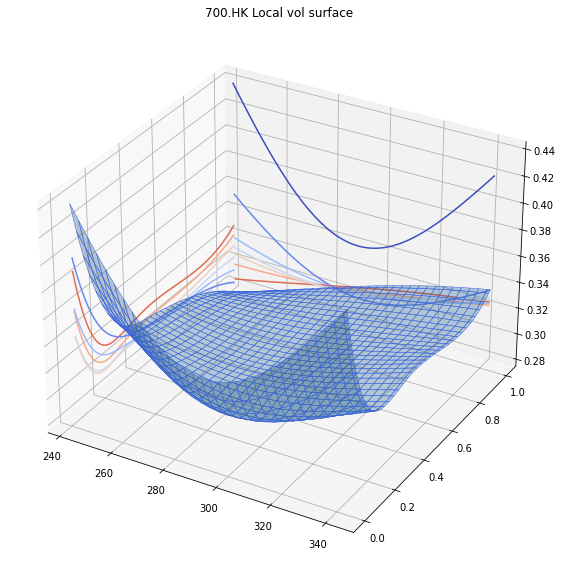

In [19]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import pyplot 

num = 252
bound = 50
x = np.linspace(S0_700-bound,S0_700+bound,num)
y = np.linspace(0,1,num) 
z = local_vol_1(y,x)
  
# displaying the visualization

x = np.array([list(x)]*num)
y = np.array([list(y)]*num).T

ax = plt.figure(figsize = (100,10)).add_subplot(projection='3d')
ax.plot_surface(x, y, z, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                alpha=0.3)
ax.set_title('700.HK Local vol surface')
ax.contour(x, y, z, zdir='x', offset=S0_700-bound, cmap='coolwarm')
ax.contour(x, y, z, zdir='y', offset=1, cmap='coolwarm')

plt.show()

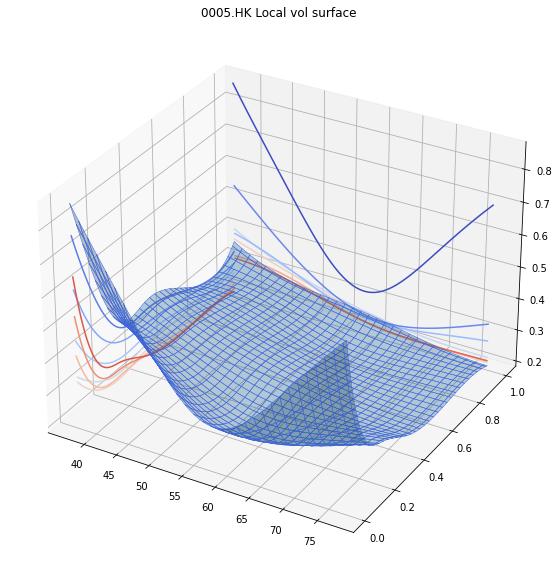

In [20]:
num = 252
bound = 20
x = np.linspace(S0_0005-bound,S0_0005+bound,num)
y = np.linspace(0,1,num) 
z = local_vol_2(y,x)
  
# displaying the visualization

x = np.array([list(x)]*num)
y = np.array([list(y)]*num).T

ax = plt.figure(figsize = (100,10)).add_subplot(projection='3d')
ax.plot_surface(x, y, z, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                alpha=0.3)
ax.set_title('0005.HK Local vol surface')
ax.contour(x, y, z, zdir='x', offset=S0_0005-bound, cmap='coolwarm')
ax.contour(x, y, z, zdir='y', offset=1, cmap='coolwarm')

plt.show()

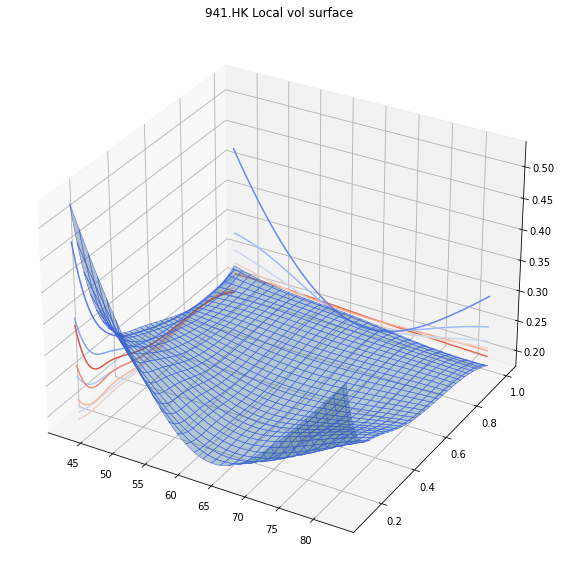

In [21]:
num = 252
bound = 20
x = np.linspace(S0_941-bound,S0_941+bound,num)
y = np.linspace(0.1,1,num) 
z = local_vol_3(y,x)
  
# displaying the visualization

x = np.array([list(x)]*num)
y = np.array([list(y)]*num).T

ax = plt.figure(figsize = (100,10)).add_subplot(projection='3d')
ax.plot_surface(x, y, z, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                alpha=0.3)
ax.set_title('941.HK Local vol surface')
ax.contour(x, y, z, zdir='x', offset=S0_941-bound, cmap='coolwarm')
ax.contour(x, y, z, zdir='y', offset=1, cmap='coolwarm')

plt.show()

# Monte Carlo Simulation and Finding PR

In [22]:
#      700     5      941
# 700    1   0.433  0.295
#  5   0.433   1    0.376
# 941  0.295 0.376    1
correlation_matrix = np.array([np.array([1, 0.433,  0.295]),np.array([0.433, 1,0.376]),np.array([0.295,0.376,1])])

In [23]:
correlation_matrix

array([[1.   , 0.433, 0.295],
       [0.433, 1.   , 0.376],
       [0.295, 0.376, 1.   ]])

In [24]:
#parameter to estimate, r,q,local vol,corr
class MC:
    def __init__(self, corr_matrix, local_vol_1,local_vol_2,local_vol_3, S0_1, S0_2, S0_3,r,q1,q2,q3):
        """ 
        corr_matrix: correlation matrix for the 3 assets
        local_vol_1/2/3 is the function/matrix for the local vol for the 3 underlying
        treat it as a function of t and strike temporarily
        S0_1 here is 700
        S0_2 here is 0005
        S0_3 here is 941
        """
        #save the input, which is the corr matrix, and the local vol function 
        self.corr_matrix = corr_matrix
        self.local_vol_1 = local_vol_1
        self.local_vol_2 = local_vol_2
        self.local_vol_3 = local_vol_3
        self.S0_1 = S0_1
        self.S0_2 = S0_2
        self.S0_3 = S0_3
        self.r = r
        self.q1 = q1
        self.q2 = q2
        self.q3 = q3
        
        self.time_step = 1*252*7*60 #252 trading days, 7 hours per day, 60 minutes per hour
        self.scenarios = 10000
        self.dt = 1/self.time_step
        np.random.seed(1)
        #time_step+1 because we set the first column to be our initial stock price
        self.bm_1 = np.random.normal(size = (self.scenarios, self.time_step+1))
        self.bm_2 = np.random.normal(size = (self.scenarios, self.time_step+1))
        self.bm_3 = np.random.normal(size = (self.scenarios, self.time_step+1))
        
        #generate the cholesky decomposition for the correlation matrix
        self.cholesky_matrix = linalg.cholesky(self.corr_matrix)
        
    def generate_zi(self, w1, w2, w3):
        return tuple(np.dot(self.cholesky_matrix,np.array([w1,w2,w3])))
                      
    def mc_underlying(self):
        """ 
        S0_1/2/3 is the initial price for the 3 underlying
        """
        self.underlying1 = pd.DataFrame().reindex_like(self.bm_1)
        self.underlying2 = pd.DataFrame().reindex_like(self.bm_2)
        self.underlying3 = pd.DataFrame().reindex_like(self.bm_3)
        self.underlyin1.iloc[:,0] = self.S0_1
        self.underlyin2.iloc[:,0] = self.S0_2
        self.underlyin3.iloc[:,0] = self.S0_3
        for i in range(1,self.time_step+1):
            for j in range(self.scenarios):
                #generate the correlated brownian motion for the 3 underlying
                z1,z2,z3 = generate_zi(self.bm_1.iloc[j,i], self.bm_2.iloc[j,i], self.bm_3.iloc[j,i])
                vol_1 = local_vol_1(t = i*self.dt, k= self.underlying1.iloc[j,i-1]/self.S0_1)
                vol_2 = local_vol_2(t = i*self.dt, k= self.underlying2.iloc[j,i-1]/self.S0_2)
                vol_3 = local_vol_3(t = i*self.dt, k= self.underlying3.iloc[j,i-1]/self.S0_3)
                self.underlying1.iloc[j,i] = self.underlying1.iloc[j,i-1]*np.exp((self.r-self.q1-(vol_1**2)/2)*dt +vol_1*z1*np.sqrt(dt))
                self.underlying2.iloc[j,i] = self.underlying2.iloc[j,i-1]*np.exp((self.r-self.q2-(vol_2**2)/2)*dt +vol_2*z2*np.sqrt(dt))
                self.underlying3.iloc[j,i] = self.underlying3.iloc[j,i-1]*np.exp((self.r-self.q1-(vol_3**2)/2)*dt +vol_3*z3*np.sqrt(dt))


In [25]:
def payoff(PR, mc_obj):
    payoff = 0
    for i in range(mc_obj.scenarios):
        #just have to check the last trading day price
        #store all payoff in an array, and then mean and discount it back
        u_1 = mc_obj.underlying1.iloc[i,-1]
        u_2 = mc_obj.underlying2.iloc[i,-1]
        u_3 = mc_obj.underlying3.iloc[i,-1]
        laggard = np.min([u_1/mc_obj.S0_1, u_2/mc_obj.S0_2, u_3/mc_obj.S0_3])
        if laggard >1:
            payoff+= 1+PR*(laggard-1)
        else:
            payoff+= np.max([laggard,0.9])
    payoff = payoff/mc_obj.scenarios
    payoff = payoff*np.exp(-mc_obj.r*1)
    return payoff

In [26]:
def minimize_PR(PR,mc_obj,target_payoff=0.98):
    
    def min_payoff(PR,mc_obj,target_payoff):
        final_payoff = payoff(PR, mc_obj)
        return np.abs(target_payoff - final_payoff)
    init_guess =1.2
    PR_min = minimize(min_payoff, init_guess, args = (mc_obj, target_payoff), method = 'SLSQP')
    return PR_min.x

In [27]:
np.dot(np.array([[1,2],[1,3]]), np.array([2,4]))

array([10, 14])